# Analyzing the scraped data with pandas and mlflow

In [389]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

In [390]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load Libraries

import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

# Downloading NLTK's databases
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load dataset in pandas

In [391]:
# future warnings
import warnings
warnings.filterwarnings("ignore")

# Use the Reddit dataset
topics_dict = { "date":[],
                "title":[],
                "author":[],
                "stickied":[],
                "upvote_ratio":[],
                "score":[],
                "id":[],
                "url":[],
                "num_comments": [],
                "created": [],
                "body":[]}
df = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/*.meta')):
    metadata = pd.read_csv(fname)

for fname in glob.glob(os.path.abspath('./data/**/*.csv')):
    _df=pd.read_csv(fname)
    _df['query'] = os.path.splitext(os.path.basename(fname))[0]
    subreddit = os.path.basename(os.path.dirname(fname))
    _df['subreddit'] = subreddit
    _df['score_weighted'] = _df['score'] / metadata[metadata['name']==subreddit]['subscribers'].iloc[0]
    _df['num_comments_weighted'] = _df['num_comments'] / metadata[metadata['name']==subreddit]['subscribers'].iloc[0]
    df = df.append(_df.copy(), ignore_index=True)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG
print(running_total)

# setup the created datetime
df['created_date'] = pd.to_datetime(df['created'], unit='s')

62622


## Run sentiment analysis

In [392]:
# Clean data

#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [393]:
# remove rows without a comment body
df.dropna(subset='body', how="any", inplace=True)

df['clean'] = df['body'].apply(lambda x: remove_emoji(cleanTxt(x)))

In [394]:
def vader_sentiment(dataset):
    # VADER sentiment analysis
    sid = SentimentIntensityAnalyzer()

    dataset[['pos', 'neg', 'neu', 'compound']] = dataset['clean'].apply(lambda text: pd.Series(sid.polarity_scores(text)))

    # Threshold conditions determine the value of the sentiment of the text
    THRESHOLD = 0.2
    conditions = [
        (dataset['compound'] <= -THRESHOLD),
        (dataset['compound'] > -THRESHOLD) & (dataset['compound'] < THRESHOLD),
        (dataset['compound'] >= THRESHOLD),
        ]
    values = ["neg", "neu", "pos"]
    dataset['label'] = np.select(conditions, values)

    # Convert all sentiment columns to numeric type
    dataset[['pos', 'neg', 'neu', 'compound']] = dataset[['pos', 'neg', 'neu', 'compound']].apply(pd.to_numeric, errors='coerce')

## Filtering dataset for GPT3 and GPT4

In [395]:
# converting created dates from reddit API into human readable format
from datetime import datetime

# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-3 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# get the distance of the date to the GPT-4 launch date
df['launch_distance'] = abs(gpt4_launch - df['created_date'])
df['launch_distance_f'] = df['launch_distance'] / pd.to_timedelta(1, unit='D')

# Filter datasets
df_gpt3 = df[(df['created_date'] >= gpt3_start) & (df['created_date'] <= gpt3_end)]

# Split at gpt4_launch date
df_gpt4_before = df[(df['created_date'] >= gpt4_start) & (df['created_date'] < gpt4_launch)]
df_gpt4_after = df[(df['created_date'] >= gpt4_launch) & (df['created_date'] <= gpt4_end)]

# apply vader sentiment to matched datasets
vader_sentiment(df_gpt3)
vader_sentiment(df_gpt4_before)
vader_sentiment(df_gpt4_after)

In [396]:

df_gpt3.describe() #3936 count
df_gpt4_before.describe() #1821 count
df_gpt4_after.describe() #10384 count

,Unnamed: 0,upvote_ratio,score,num_comments,created,score_weighted,num_comments_weighted,launch_distance,launch_distance_f,pos,neg,neu,compound
count,7186.000000,7186.000000,7186.000000,7186.000000,7.186000e+03,7186.000000,7186.000000,7186,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000
mean,1308.272474,0.907897,2590.818954,424.175758,1.681434e+09,0.006916,0.001127,31 days 01:06:15.650013916,31.046014,0.045888,0.840807,0.113014,0.608252
std,791.959025,0.101435,4686.361973,741.385185,1.476895e+06,0.018835,0.003005,17 days 02:14:54.726580965,17.093689,0.064766,0.098919,0.073173,0.580954
min,1.000000,0.250000,0.000000,0.000000,1.678839e+09,0.000000,0.000000,1 days 00:12:18,1.008542,0.000000,0.000000,0.000000,-0.998100
25%,838.000000,0.880000,26.000000,8.000000,1.680216e+09,0.000027,0.000007,16 days 22:40:29,16.944780,0.005000,0.807000,0.079000,0.422300
50%,1170.000000,0.940000,186.000000,70.000000,1.681472e+09,0.000211,0.000065,31 days 11:33:56,31.481898,0.037000,0.855000,0.107000,0.929900
75%,1756.000000,0.980000,3085.000000,456.000000,1.682701e+09,0.003298,0.000594,45 days 17:01:49,45.709595,0.056000,0.894000,0.138000,0.993800
max,3450.000000,1.000000,22371.000000,3835.000000,1.684078e+09,0.150882,0.025865,61 days 15:20:13,61.639039,0.565000,1.000000,0.510000,0.999800


In [397]:


def get_variable_name(var):
    """
    Get the name of the variable passed into the function.
    """
    # Get the calling frame
    frame = inspect.currentframe().f_back
    
    # Get the caller's namespace
    namespace = frame.f_locals
    
    # Search for the variable name based on its value
    for name in namespace:
        if namespace[name] is var:
            return name
    return None

In [398]:
# Features to measure with MLflow
feature_names = ['launch_distance_f', 'num_comments_weighted', 'stickied', 'upvote_ratio', 'created', 'compound', 'pos', 'neg', 'neu']
# Target MLflow value
target_name = 'score_weighted'

# these variables should be represented as log of the original values
log_variables = ['score_weighted','num_comments', 'launch_distance_f', 'created']
# These features are disabled. Stickied items throw off the counts.
for feature in ['stickied']: feature_names.remove(feature)

def clean_dataset(dataset, csv_name, inplace=True):
    global log_variables, feature_names, target_name
    if inplace is True:
        _dataset = dataset
    else:
        _dataset = dataset.copy()
    for variable in log_variables:
        # Rename the variables to log_[variable] in the datasets
        log_variable = 'log_'+variable
        if target_name == variable:
            target_name = log_variable
        elif variable in feature_names:
            feature_names[feature_names.index(variable)] = log_variable
        _dataset[log_variable] = _dataset[variable].apply(lambda value: np.log(value+1))
    _dataset.dropna(subset=feature_names, how="any", inplace=True)
    _dataset.dropna(subset=target_name, how="any", inplace=True)
    
    ## Output file to csv
    _dataset.to_csv('/'.join(['output', csv_name + '.csv']))
    return _dataset

clean_dataset(df_gpt3, 'gpt3')
clean_dataset(df_gpt4_before, 'gpt4-before')
clean_dataset(df_gpt4_after, 'gpt4-after')

print(f"feature_names={feature_names}")
print(f"target_name={target_name}")

feature_names=['log_launch_distance_f', 'num_comments_weighted', 'upvote_ratio', 'log_created', 'compound', 'pos', 'neg', 'neu']
target_name=log_score_weighted


In [399]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def trim_dataset(dataset, q_lower = .1, q_upper = .9):
    global target_name
    quantile = target_name
    _dataset = dataset.copy()
    # Trim dataset by the quantile for the target for training
    _dataset = _dataset[(_dataset['stickied'] == False)]
    _q_lower = _dataset[quantile].quantile(q_lower)
    _q_upper = _dataset[quantile].quantile(q_upper)
    _dataset = _dataset[(_dataset[quantile] > _q_lower) &
                        (_dataset[quantile] < _q_upper)]
    return _dataset

def model_testing(dataset, test):
    _dataset = dataset.copy()
    _test = test.copy()
    # Trim upper and lower quantiles
    _dataset = trim_dataset(_dataset)
    _test = trim_dataset(_test)
    # Sort values for displaying in graph
    _dataset = dataset
    _test = _test
    # Set X features and y targets
    X_test = _test.loc[:, _test.columns[:,None] == feature_names]
    y_test = _test.loc[:, _test.columns == target_name].values
    X = _dataset.loc[:, _dataset.columns[:,None] == feature_names]
    y = _dataset.loc[:, _dataset.columns == target_name].values

    lr_params =  {}
    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_actual': y_test, 'y_pred': y_pred, 'coef': lr.coef_}

gpt3_model = model_testing(df_gpt3, df_gpt4_after)
gpt3_model_same = model_testing(df_gpt3, df_gpt3)
gpt4_model = model_testing(df_gpt4_before, df_gpt4_after)
gpt4_model_same = model_testing(df_gpt4_before, df_gpt4_before)

2024/02/18 23:00:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/18 23:00:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0e233340ea194216a9ab026b095b9ab4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/18 23:00:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2d8ec60ddd00453aab99bcbcbfe445e2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/18 23:00:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '63b67d0779fa471d8eded4820621c55e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/18 23:01:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3fda31855d9b4108ba3b3ea54

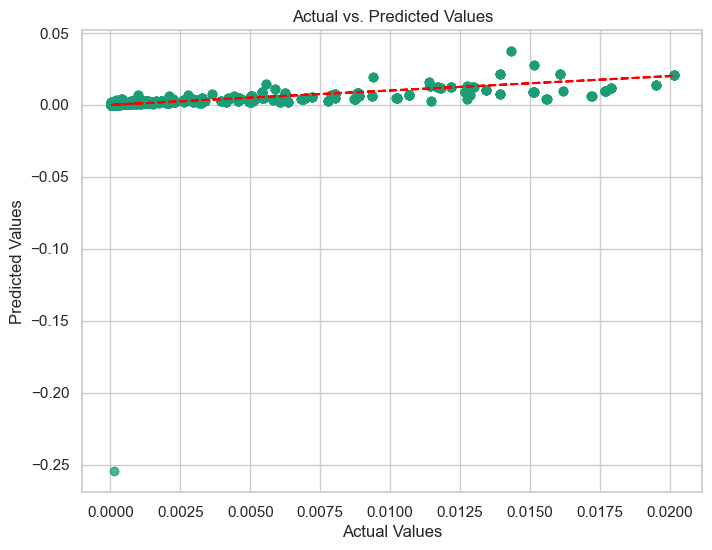

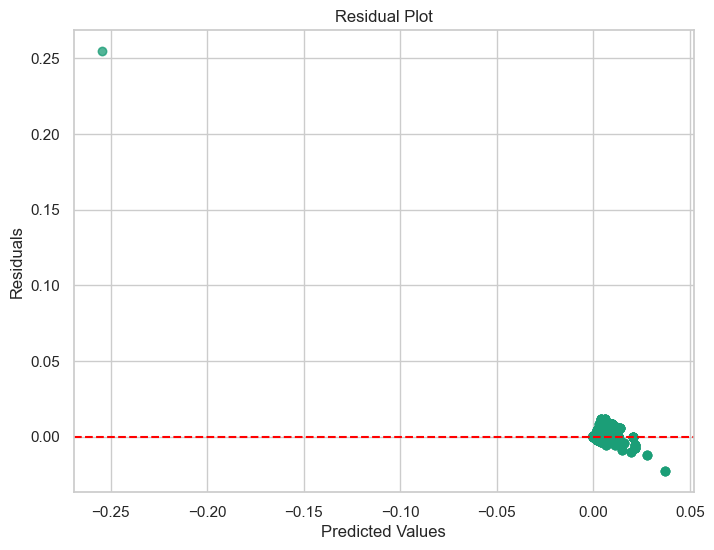

In [400]:
model = gpt4_model
actual_values = model['y_actual']
predicted_values = model['y_pred']

# Scatter plot of actual versus predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.plot(actual_values, actual_values, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.grid(True)
plt.show()

# Residual plot
residuals = actual_values - predicted_values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Coefficient plot (if coefficients are available in the MLflow run)
if "coefficients" in model:
    coefficients = model["coef"]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=coefficients.index, y=coefficients.values)
    plt.xlabel("Independent Variables")
    plt.ylabel("Coefficients")
    plt.title("Coefficient Plot")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

log_launch_distance_f=0.0001688318320620477


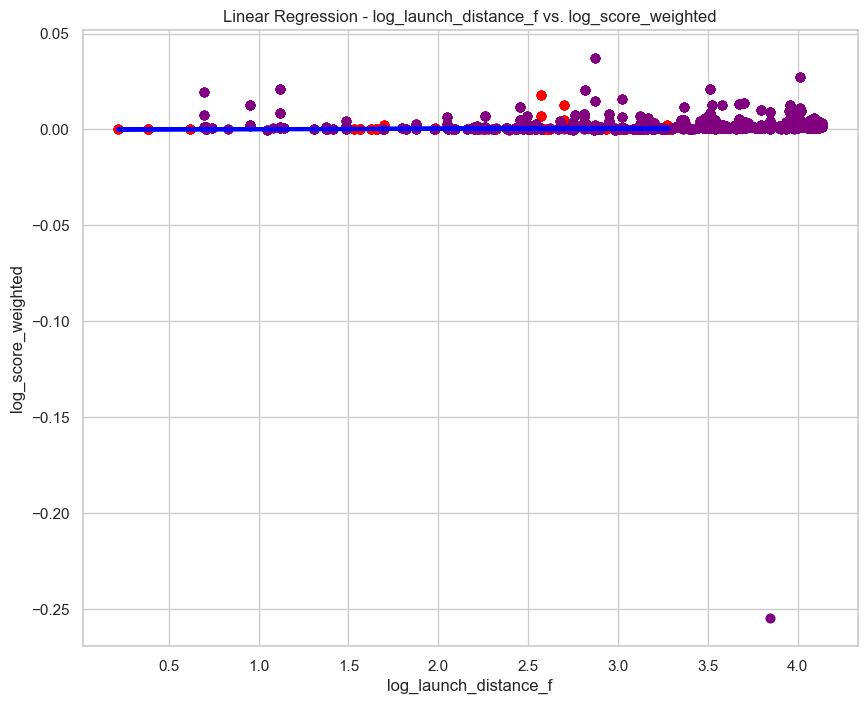

num_comments_weighted=3.7400639766919372


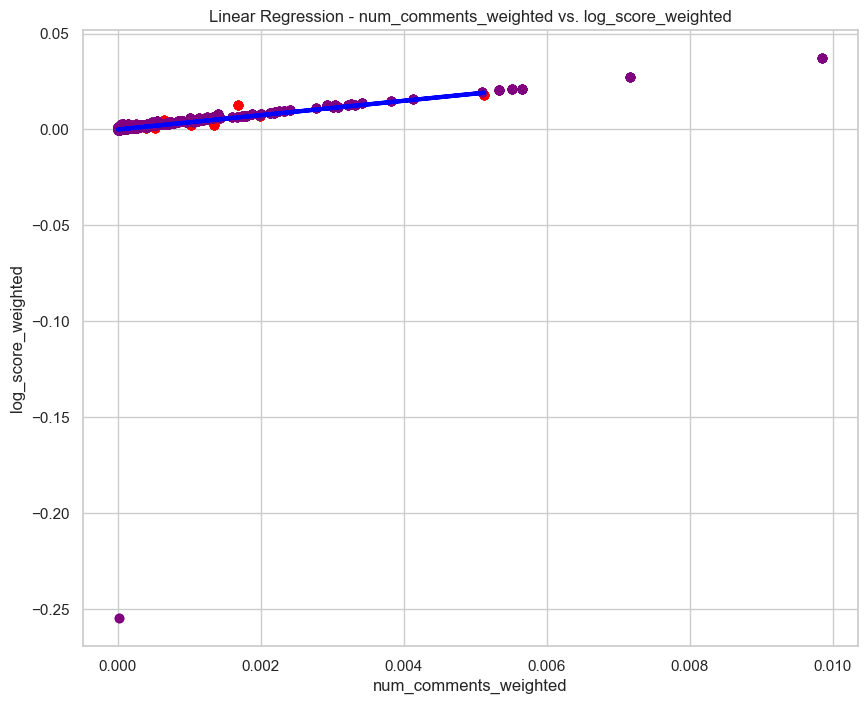

upvote_ratio=0.25666519081571215


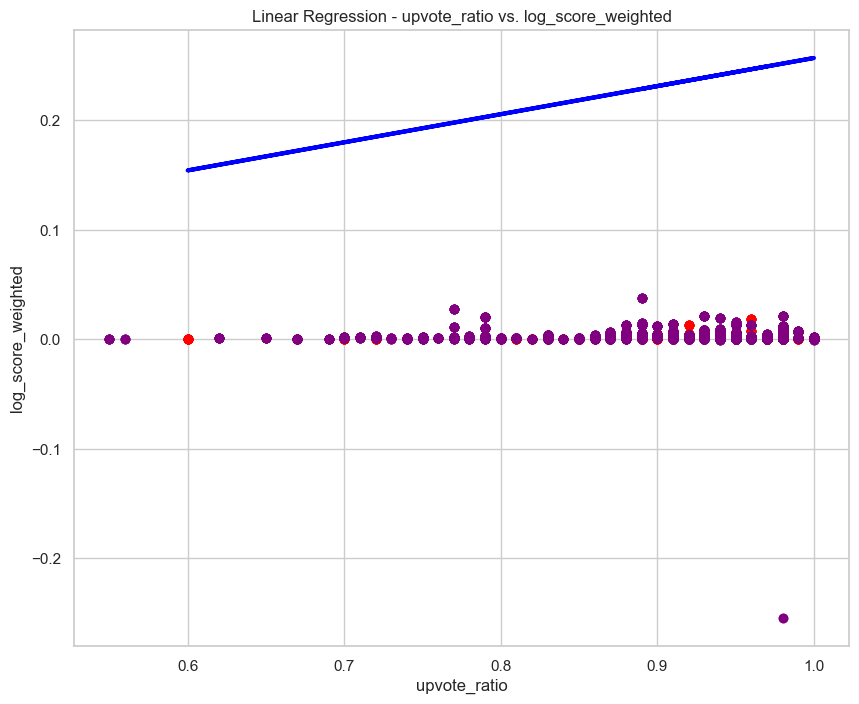

log_created=0.254986700298654


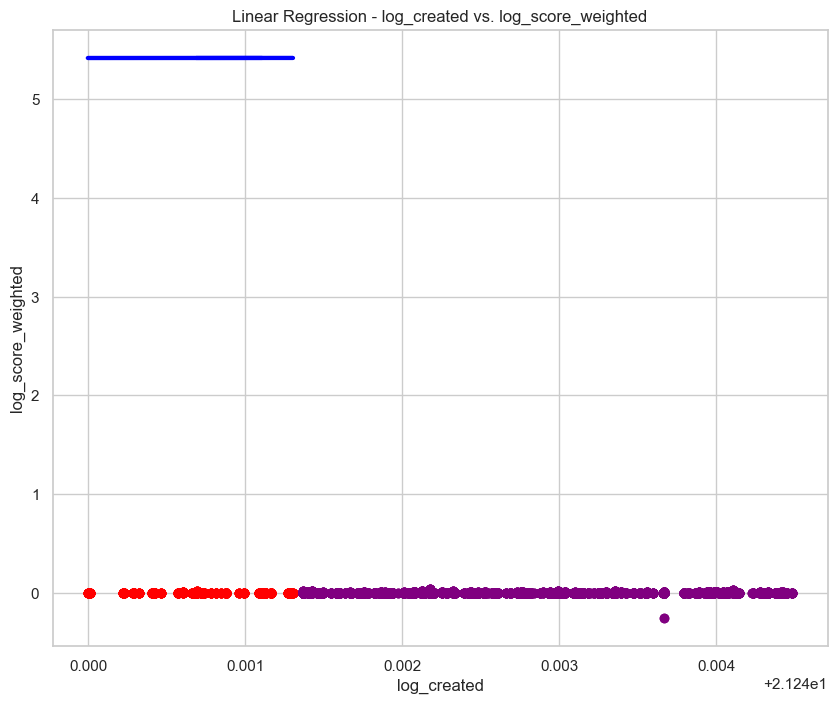

compound=0.2592078505313998


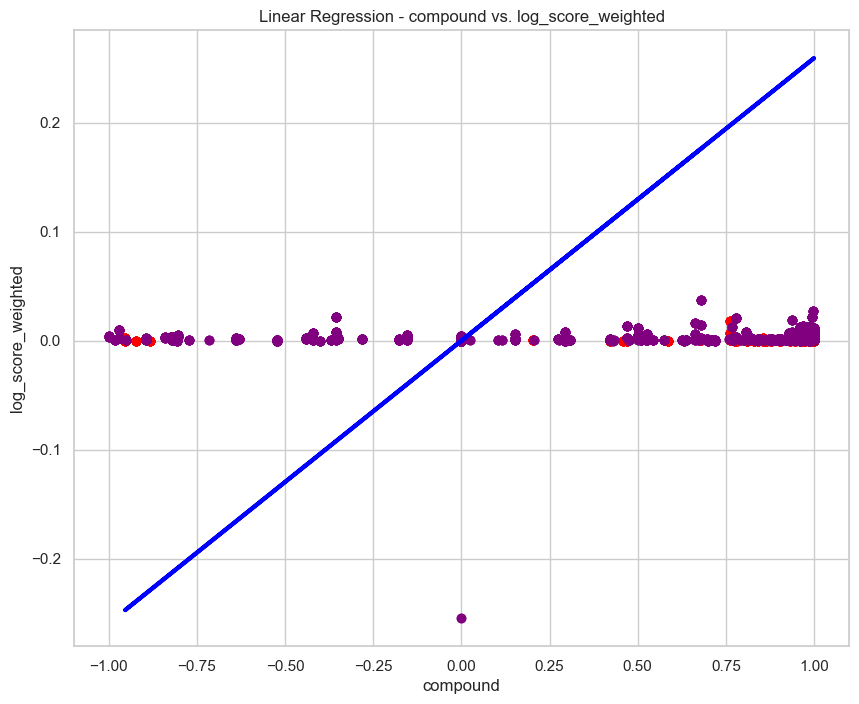

pos=3.409054226288788e-05


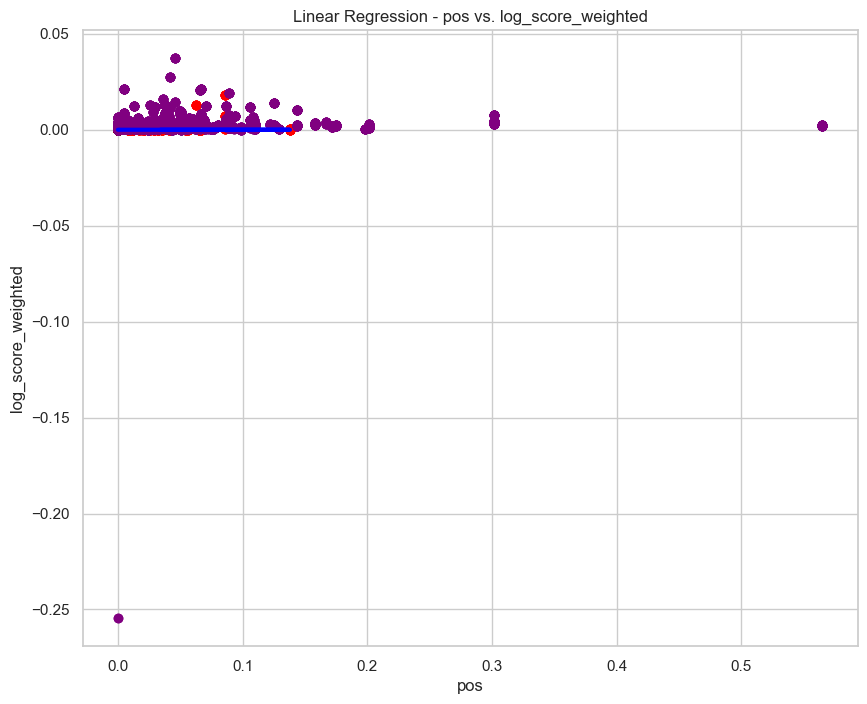

neg=8.478550332924328e-05


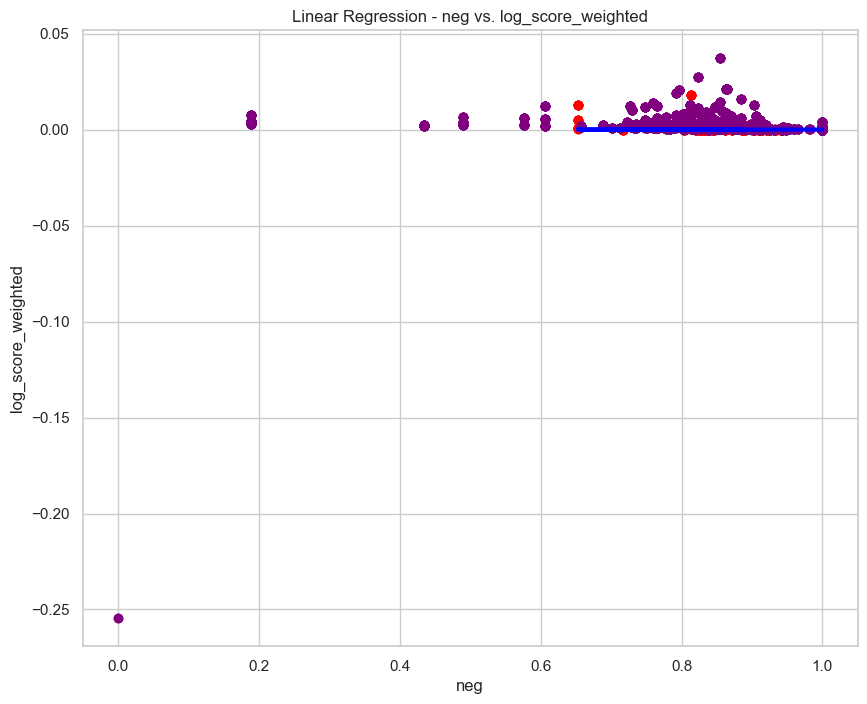

neu=0.22035240722387053


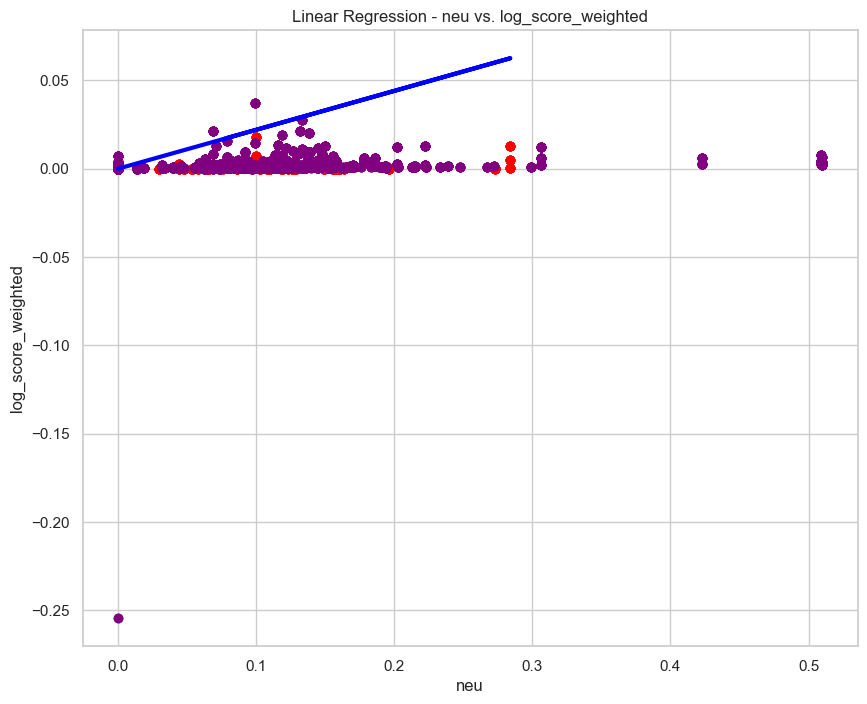

In [401]:
model = gpt4_model
for coef in feature_names:
    print(f"{coef}={model['coef'][0][feature_names.index(coef)]}")
    feature = coef
    plt.scatter(model['X'][feature], model['y'], color='red')
    plt.scatter(model['X_test'][feature], model['y_pred'], color='purple')
    y_fit = model['X'][feature] * model['coef'][0][feature_names.index(feature)]
    plt.plot(model['X'][feature], y_fit, color='blue', linewidth=3)
    plt.xlabel(f"{feature}")
    plt.ylabel(f"{target_name}")
    plt.title(f"Linear Regression - {feature} vs. {target_name}")
    plt.show()